In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
sys.path.append("code")
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from keras_tqdm import TQDMNotebookCallback
from npm3dGenerator_tree import NPM3DGenerator, NPM3DGenerator_full
from models import build_point_net, save_model, load_model
import utils_training as u_t

Using TensorFlow backend.


../Benchmark_MVA/training\MiniLille2_tree.joblib
LOADING TREE
DONE
MODIFIYING PATHS ../Benchmark_MVA/training\MiniLille2.ply
LOADING NORMALS ../Benchmark_MVA/training\MiniLille2_normals.npy
../Benchmark_MVA/training\MiniParis1_tree.joblib
LOADING TREE
DONE
MODIFIYING PATHS ../Benchmark_MVA/training\MiniParis1.ply
LOADING NORMALS ../Benchmark_MVA/training\MiniParis1_normals.npy



../Benchmark_MVA/training\MiniLille1_tree.joblib
LOADING TREE
DONE
MODIFIYING PATHS ../Benchmark_MVA/training\MiniLille1.ply
LOADING NORMALS ../Benchmark_MVA/training\MiniLille1_normals.npy



NPM3DGenerator config
n_classes         : 6
batch_size        : 8
n_points          : 4096
n_channels        : 9
train             : True
use_normals       : True
normal_radius     : 0.75
compute_normals   : True
class_weight      : [0.04005 0.04414 2.41484 2.82370 0.62399 0.05329]


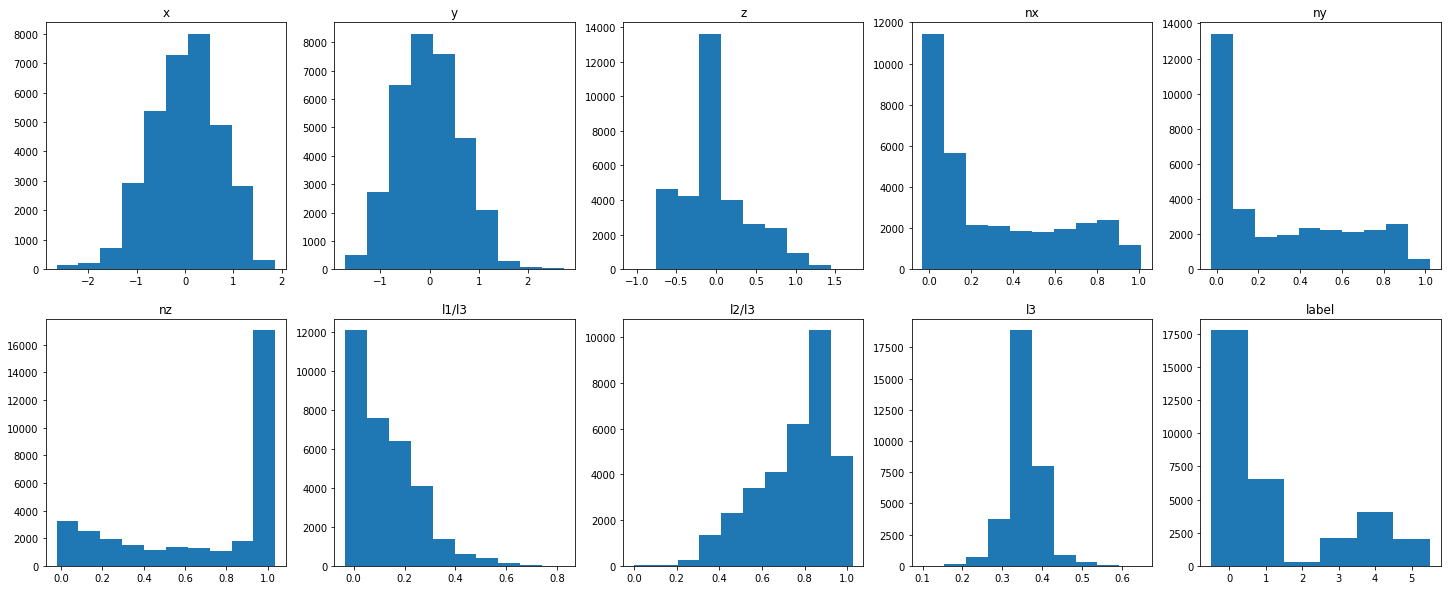

In [2]:
use_normals = True
sample_uniformly_from_classes = True

training_dataset = NPM3DGenerator(paths_to_keep = [1, 2], use_normals = use_normals,
                                  sample_uniformly_from_classes = sample_uniformly_from_classes)
validation_data = NPM3DGenerator(paths_to_keep = [0], use_normals = use_normals,
                                 sample_uniformly_from_classes = sample_uniformly_from_classes, evaluation = True).get_data()
print(training_dataset)
training_dataset.show_samples()

In [ ]:
import keras

batchnorm = True

miou_metric = u_t.mIoU(training_dataset.n_classes)

model = build_point_net(input_shape = (training_dataset.n_points, training_dataset.n_channels),
                        output_shape = training_dataset.n_classes, normalize = batchnorm)
#model = load_model("models/trained_{}_{}_{}".format(training_dataset.n_points, training_dataset.n_channels, training_dataset.n_classes))
model.compile("adam", u_t.my_categorical_crossentropy, metrics = ["accuracy", miou_metric.miou])
#keras.optimizers.Adam(lr=0.001, beta_1=0.75, beta_2=0.99, epsilon=None, decay=0.0, amsgrad=False)
#model.summary()

In [ ]:
from keras.callbacks import EarlyStopping

n_epochs = 200
patience = 5
history = model.fit_generator(training_dataset, epochs = n_epochs,
                              validation_data = validation_data,
                              class_weight = training_dataset.class_weight,
                              verbose = 0, callbacks=[EarlyStopping(monitor = 'val_loss', patience = patience, verbose = 0),
                                                      TQDMNotebookCallback(leave_inner=True, leave_outer=True)])
u_t.plot_history(history)

In [ ]:
model_name = "models/trained_{}_{}_{}__25e_uniform_nobatchnorm".format(training_dataset.n_points, training_dataset.n_channels, training_dataset.n_classes)
save_model(model, model_name)

In [ ]:
training_dataset = NPM3DGenerator(paths_to_keep = [1, 2], use_normals = use_normals, sample_uniformly_from_classes = True)
print(training_dataset)
training_dataset.show_samples()

n_epochs = 200
patience = 10
history = model.fit_generator(training_dataset, epochs = n_epochs,
                              validation_data = validation_data,
                              class_weight = training_dataset.class_weight,
                              verbose = 0, callbacks=[EarlyStopping(monitor = 'val_loss', patience = patience, verbose = 0),
                                                      TQDMNotebookCallback(leave_inner=True, leave_outer=True)])
u_t.plot_history(history)

In [ ]:
test_dataset = NPM3DGenerator(input_dir = "../Benchmark_MVA/test", train = False)
#model = load_model("models/trained_{}_{}_{}".format(test_dataset.n_points, test_dataset.n_channels, test_dataset.n_classes))
probas, predictions = test_dataset.predict_point_cloud(model)
try:np.savetxt('predictions_{}.txt'.format(model_name.split("/")[-1]), predictions, fmt='%d')
except:np.savetxt('predictions.txt', predictions, fmt='%d')

plt.hist(predictions)
plt.show()

plt.figure(figsize = (15, 7))
for i in range(test_dataset.n_classes):
    plt.subplot(231 + i)
    plt.title(test_dataset.class_dict[i + 1])
    plt.hist(np.max(probas[predictions == 1 + i], axis = -1), normed = True)
plt.show()